# Выбор локации для скважины

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**ПЛАН:**

1. Загрузка и обзор данных:
   - Анализ объемов запасов в скажинах
   - Проверка пропусков
   - Проверка на дубликаты
   - Корреляция данных
2. Создание модели.
3. Подготовка к расчёту прибыли.
4. Расчёт прибыли и рисков.

## Загрузка и подготовка данных

In [1]:
#импортируем библиотеки подгружаем модули необходимые нам в процессе работы
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.stats as st
from numpy.random import RandomState
state = RandomState(12345)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Необходимые данные для расчета
#в каждом регионе исследуют 500 точек
ALL_POINTS = 500
#в каждом оставляют 200 лучших
BEST_POINTS = 200
#бюджет на разработку 10 млрд рублей
BUDGET = 10e9
#1 баррель приносит 450 рублей дохода, объем скважин указывается в тыс бареллях, то сеть единица доходности 450 тыс
PROFIT_PER_BARREL = 450000
#максимально допустимый риск убытков 2.5%
MAX_RISC_DAMAGE = 0.025

### Исследование данных

In [3]:
#Загрузим наши данные и сохраним их в датафреймах

try:
    df_0 = pd.read_csv('/Users/mariaspartalan/Desktop/готовые проекты/6 ГлавГосРосНефть/geo_data_0.csv')
    df_1 = pd.read_csv('/Users/mariaspartalan/Desktop/готовые проекты/6 ГлавГосРосНефть/geo_data_1.csv')
    df_2 = pd.read_csv('/Users/mariaspartalan/Desktop/готовые проекты/6 ГлавГосРосНефть/geo_data_2.csv')
    
except FileNotFoundError :
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')
finally:
    print('Данные подгрузились')

 

Данные подгрузились


In [4]:
#Рассмотрим первые строки каждого из них внимательнее
df_0.head(5)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df_1.head(5)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
df_2.head(5)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
print(df_0.info())
print()
print(df_1.info())
print()
print(df_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column

Мы загрузили 3 массива данных.

Это 3 таблицы одинакового размера. В каждой содержится информация о скважинах в 3 регионахб в каждой по 100000.

Все таблицы имеют схожу структуру.

- id - уникальный идентификатор скважины.
- f0, f1, f2 - характеристики скважин.
- product - объем запасов в скважине (тыс. баррелей).



Рассмотрим подробнее значения product по регионам

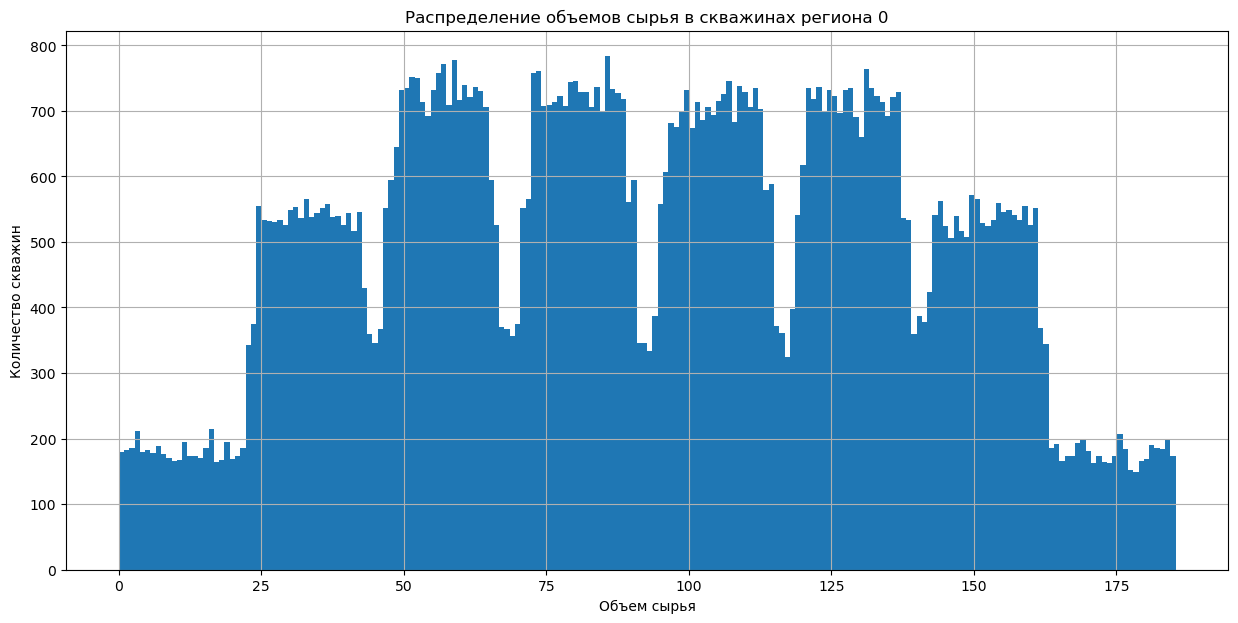

In [8]:
df_0['product'].hist(bins = 200, figsize = (15, 7))
plt.title('Распределение объемов сырья в скважинах региона 0')
plt.xlabel('Объем сырья')
plt.ylabel('Количество скважин')
plt.show;

На графике первого региона отчетливо видны несколько мод, общая тенденция нормальная.

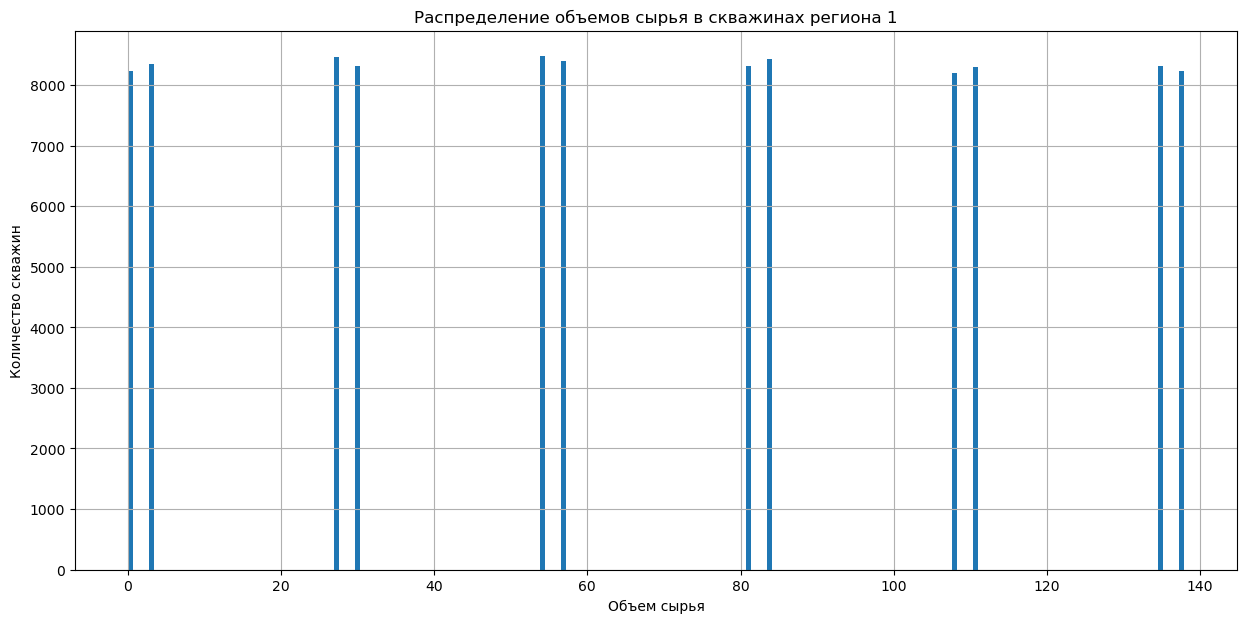

In [9]:
df_1['product'].hist(bins = 200, figsize = (15, 7))
plt.title('Распределение объемов сырья в скважинах региона 1')
plt.xlabel('Объем сырья')
plt.ylabel('Количество скважин')
plt.show;

В целом объемы примерно такие же как и в предыдущем регионе, но распределение не стабильное. Нужно перепроверить предоставленные данные. Показатели все концентрируеются в точках с шагом в 25-30 баррелей.

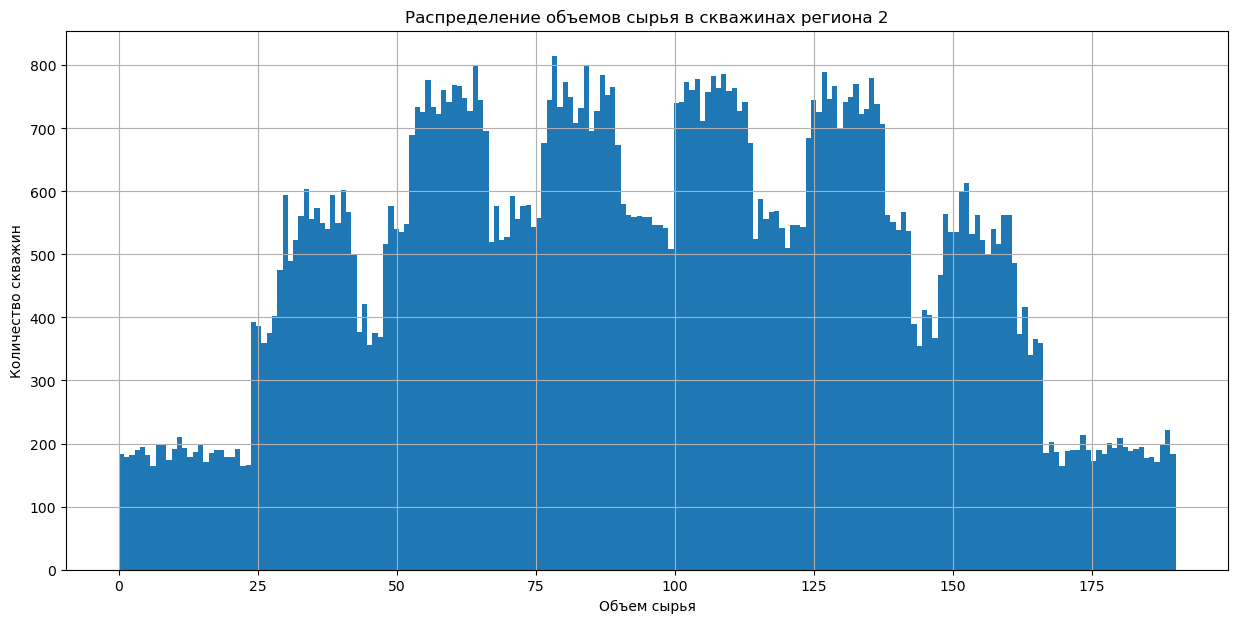

In [10]:
df_2['product'].hist(bins = 200, figsize = (15, 7))
plt.title('Распределение объемов сырья в скважинах региона 2')
plt.xlabel('Объем сырья')
plt.ylabel('Количество скважин')
plt.show;

в регионе 2 на графике распределения  тоже видны несколько мод, но в целом тенденция стремится к нормальной. Ситуация аналогична с регионом 0.

### Предобработка данных

#### Проверка на пропуски
Проверим данные на пропуски.

In [11]:
print('В первом массиве {} пропусков'.format(df_0.isna().sum().sum()))
print('Во втором массиве {} пропусков'.format(df_1.isna().sum().sum()))
print('В третьем массиве {} пропусков'.format(df_2.isna().sum().sum()))

В первом массиве 0 пропусков
Во втором массиве 0 пропусков
В третьем массиве 0 пропусков


#### Проверка на дубликаты

In [12]:
print('В первом массиве {} пропусков'.format(df_0.duplicated().sum()))
print('Во втором массиве {} пропусков'.format(df_1.duplicated().sum()))
print('В третьем массиве {} пропусков'.format(df_2.duplicated().sum()))

В первом массиве 0 пропусков
Во втором массиве 0 пропусков
В третьем массиве 0 пропусков


Так же проверим на данные на неявные дубликаты.

В данных содержаться данные о 100000 уникальных скважиных, это подразумевает, что не должно быть повторов в графе с уникальным id. Проверим это.


In [13]:
i = 0

for r in [df_0, df_1, df_2]:
    print('По региону {} значение id потворяется {} раз'.format(i, r['id'].duplicated().sum()))
    i += 1

По региону 0 значение id потворяется 10 раз
По региону 1 значение id потворяется 4 раз
По региону 2 значение id потворяется 4 раз


Повторов не так много, но они имеются, при расчете мы их исключим и сообщим об этой ошибке.

In [14]:
#Перезапишем данные, удалив строки с повторяющимся id

i = 0

for r in [df_0, df_1, df_2]:
    r = r.drop_duplicates(subset = ['id'], ignore_index = True)
    print('По региону {} осталось {} дубликатов'.format(i, r['id'].duplicated().sum()))
    i +=1

По региону 0 осталось 0 дубликатов
По региону 1 осталось 0 дубликатов
По региону 2 осталось 0 дубликатов


#### Подсчет коореляции

In [15]:
print('Матрица корреляции для региона 0')
df_0.drop('id', axis=1).corr()

Матрица корреляции для региона 0


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


Матрица корреляции для региона для региона 0


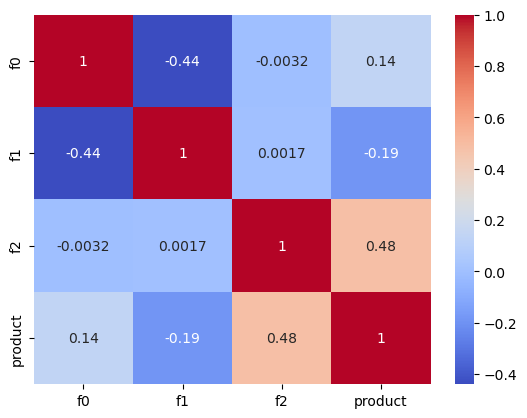

Матрица корреляции для региона для региона 1


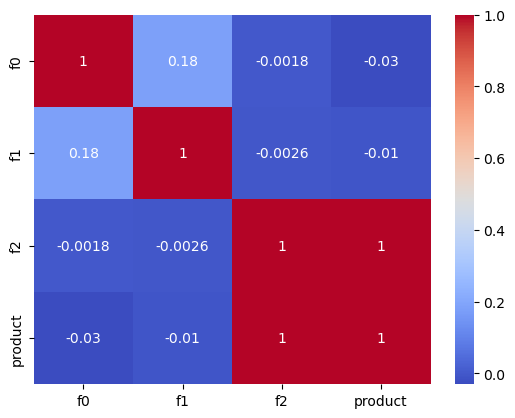

Матрица корреляции для региона для региона 2


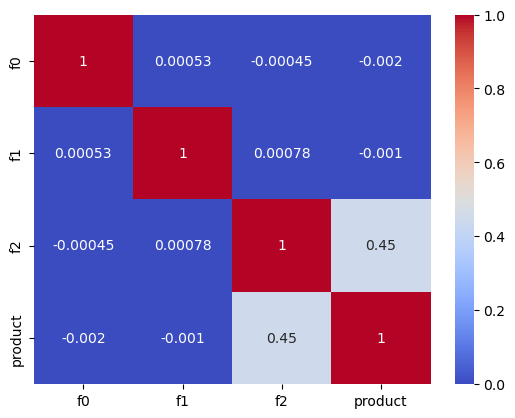

In [16]:
z=0
for i in (df_0, df_1, df_2):
    print(f"Матрица корреляции для региона для региона {z}")
    sns.heatmap(i.drop('id', axis=1).corr(), annot=True, cmap='coolwarm')
    plt.show()
    z += 1;

Все показатели между признаками для региона 0 по модулю меньше 0.5, значит коореляция слабая.

Есть большая коореляция между признаком f2 и объемом сырья в регионе 1.

Как мы выяснили раньше в этом регионе также своебразное повторяющееся распределение объемов сырья. 

Лишний раз подтверждает необходимость перепроверить данные компании которая их предоставила.

Все показатели между признаками для региона 2 по модулю меньше 0.5, значит кореляция слабая.

Все показатели между признаками для региона 2 по модулю меньше 0.5, значит кореляция слабая.

________
**ПРОМЕЖУТОЧНЫЙ ВЫВОД:**

На данном этапе работ загружены данные, для каждого сделаны отдельный датафрейм.

Расммотрены внимательно значения product.
В регионах 0 и 2 значения доход по скважинам распределено волнообразно, с нормальной тенденцией.
В регионе 1 выявлена аномалия. Она вызвана или ошибкой в данных, в данных, или наличием пустых скважин.

Данные проверенына пропуски и дубликаты. Оные отсутствуют. 

Так же id по регионам проверены на уникальность, дублирующиеся значения удалены.

Данные по регионам проверены на корреляцию. В показатели везде низкие. Исключением явлется только корреляция f2 и product по региону 1.

## Обучение и проверка модели
### Создание модели

Нам нужно провести одинаковый объем работы по 3 регионам, для удобства пропишем функцию

In [17]:
def analize_region(df):
    #Удалим данные id, они не понадобятся нам для работы модели, а так же целевой признак product
    features = df.drop(['id', 'product'], axis = 1)
    target = df['product']
    #Разобьем данные на обучающую и валидационную выборки в соотношение 75:25
    features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                                 test_size = 0.25,
                                                                                 random_state = state)
    #Стандартизируем признаки
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    #Создадим и обучим модель линейной регрессии (согласно изначальному заданию)
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predictions = pd.Series(predictions)
    
    #Рассчитаем RMSE и средний предсказанные объем сырья
    rmse = mean_squared_error(target_valid, predictions) ** 0.5
    average_product = sum(predictions) / len(predictions)
    
    print('RMSE = ', rmse)
    print('Средний запас предсказанного сырья на 1 скважину', average_product)

    return (predictions, target_valid.reset_index(drop=True), rmse)

In [18]:

i = 0
for region in [df_0, df_1, df_2]:
    print(f"Данные для региона {i}:")
    print()
    analize_region(region)
    print()
    i+=1

Данные для региона 0:

RMSE =  37.5794217150813
Средний запас предсказанного сырья на 1 скважину 92.59256778438005

Данные для региона 1:

RMSE =  0.8897367737680648
Средний запас предсказанного сырья на 1 скважину 68.7699514579978

Данные для региона 2:

RMSE =  39.958042459521614
Средний запас предсказанного сырья на 1 скважину 95.08752812252328



___________
**ПРОМЕЖУТОЧНЫЙ ВЫВОД:**

   В результате проведенных иследований выяснено, что самый высокий средний уровень сырья, 95 тыс баррелей на скважину, в регионе 2, но так же здесь и выше средняя квадратичная ошибка предсказанных значений, она составляет 39.95.
    
   Второй по точности  и по объему запасов регион 0, запас на скважину 92.6 тыс баррелей, ошибка 37.58.
    
   Самый маленький запас на скважину в регионе 1, 68 баррелей, но тут самая маленькая квадратичная ошибка6 всего 0.88. Нужно перепроверить исходные данные. 
    Так же возможно, что в этом регионе большое количество пустых скважин, отсюда никая средняя оценка.

## Подготовка к расчёту прибыли

Подготовим данные, которые понадобяться нам в процессе работы

In [19]:
#сохраним данные рассчитанные в предыдущем пункте
predictions_0, target_valid_0, rmse_0 = analize_region(df_0)
predictions_1, target_valid_1, rmse_1 = analize_region(df_1)
predictions_2, target_valid_2, rmse_2 = analize_region(df_2)

RMSE =  37.57951548534859
Средний запас предсказанного сырья на 1 скважину 92.66386568661606
RMSE =  0.890416321494619
Средний запас предсказанного сырья на 1 скважину 69.22345150014004
RMSE =  40.02938636981283
Средний запас предсказанного сырья на 1 скважину 95.04953599535943


Расчитаем минимальные допустимые экономические параметры для разработки регионов.

In [20]:
barr_per_point = BUDGET / BEST_POINTS / PROFIT_PER_BARREL

In [21]:
print('Общее количества сырья в регионе {} тыс баррелей'.format(round(BUDGET / PROFIT_PER_BARREL)))
print('Достаточный объем сырья в скважине для ее безубыточной разработки {}'.format(round(barr_per_point)))
print('Средняя выручка с каждой скважины {}'.format(round(BUDGET/BEST_POINTS)))

Общее количества сырья в регионе 22222 тыс баррелей
Достаточный объем сырья в скважине для ее безубыточной разработки 111
Средняя выручка с каждой скважины 50000000


__________
**ПРОМЕЖУТОЧНЫЙ ВЫВОД:**

Для того чтобы окупить вложения в исследование региона и разработку скважин, необходимо определить 200 сместонахождений со средним объемом сырья 111 тыс баррелей.

В предыдущем пункте нашей работы мы предсказали средний уровень сырья в скважине по регионам 92, 68 И 95. В каждом представлены данные о 100000 скважин.

Сравнивая текущие значения ожидаемого запаса сырья в точке и необходимый для безубыточной работы запас сырья, мы приходим к выводу, что ни в одном регионе его недостаточно. 

Важно понимать, что среднее ожидаемое значение сырья в точке по региона рассчитано на основе 25 000 точек, из которых мы можем разработать только 200 - само собой, что среди них могут оказать как плохие, так и хорошие скважины с точки зрения запаса в них продукта.

Случайным образом отбирая точки и считая финансовый результат работы в них, мы можем оценить прибыль и риски работы в регионе - это и есть обоснование дальнейшей процедуры бутстрапирования.

Проделаем ее в следующем пункте работы.

## Расчёт прибыли и рисков 

### Расчет прибыли

Напишем функцию для расчет прибыли по регионам

In [26]:
def profit(predictions, target):
    top_preds = predictions.sort_values(ascending=False)
    top_target = target[top_preds.index][:200]
    revenue = top_target.sum() * PROFIT_PER_BARREL
    return (revenue - BUDGET) / 1000000

In [27]:
print('Прибыль региона 0 с вычетом затрат на исследование и разработку составит {} млн. рублей'.
      format(profit(predictions_0, target_valid_0)))
print()
print('Прибыль региона 1 с вычетом затрат на исследование и разработку составит {} млн. рублей'.
      format(profit(predictions_1, target_valid_1)))
print()
print('Прибыль региона 2 с вычетом затрат на исследование и разработку составит {} млн. рублей'.
      format(profit(predictions_2, target_valid_2)))

Прибыль региона 0 с вычетом затрат на исследование и разработку составит 3333.004211947521 млн. рублей

Прибыль региона 1 с вычетом затрат на исследование и разработку составит 2415.086696681511 млн. рублей

Прибыль региона 2 с вычетом затрат на исследование и разработку составит 2697.49487789637 млн. рублей


In [30]:
def find_conf_interval_and_loss_risk(predictions, target):
    
    profit_calc = []
    
    for x in range(1000):
    
        target_sample = target.sample(ALL_POINTS, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        profit_calc.append(profit(predictions_sample, target_sample))   
        
    lower = int(np.percentile(profit_calc, 2.5))
    higher = int(np.percentile(profit_calc, 97.5))
    mean_revenue = int(sum(profit_calc) / len(profit_calc))
    risk = st.percentileofscore(profit_calc, 0)

    return ((lower, higher), mean_revenue, risk)

In [31]:
i = 0
for preds, target in zip([predictions_0, predictions_1, predictions_2], 
                         [target_valid_0, target_valid_1, target_valid_2]):
    interval, mean_revenue, risk = find_conf_interval_and_loss_risk(preds, target)
    print('Регион {}'.format(i))
    print('\n-----------------------------------------')
    print('Доход: {}'.format(mean_revenue))
    print('95% доверительный интервал: {}'.format(interval))
    print('Риск убытка: {}'.format(risk))
    print('-----------------------------------------\n\n')
    i+=1

Регион 0

-----------------------------------------
Доход: 429
95% доверительный интервал: (-84, 937)
Риск убытка: 5.300000000000001
-----------------------------------------


Регион 1

-----------------------------------------
Доход: 545
95% доверительный интервал: (163, 976)
Риск убытка: 0.2
-----------------------------------------


Регион 2

-----------------------------------------
Доход: 432
95% доверительный интервал: (-153, 967)
Риск убытка: 6.4
-----------------------------------------




На основании полученных результатов, можно предположить, что самым перспективным для разработки будет регион 1Б так как прибыль максимальна, а риски убытков минимальны.

__________
**ОБЩИЙ ВЫВОД:**


* В ходе данной работы были загружены массивы данных по 3 регионам. В каждом из них информация о 100000 скважиных.
 Данные были обработаны, проверены на наличие дубликатов, пропусков. 
 
 Так же id по регионам проверены на уникальность, дублирующиеся значения удалены.
 
 Данные по регионам проверены на корреляцию. В показатели везде низкие. Исключением явлется только корреляция f2 и product по региону 1.
 
 ***Была выявлена аномалия в данных по региону 1:***


 Данные о запасах сырья в этом регионе распределены, не очень равномерно, а снеким интервалом. Информация представлена на графике выше. Для дальнейших результатов, данные не подвергались изменениям.
 
* Была создана модель, которая предсказывала объем сырья в скважине, основываясь на полученных данных. По результатам работы модели были вычислены средняя квадратичная ошибка предсказания и средний объем сырья со скважины на регион:

Данные для региона 0:

RMSE =  37.5794217150813
Средний запас предсказанного сырья на 1 скважину 92.59256778438008

Данные для региона 1:

RMSE =  0.889736773768065
Средний запас предсказанного сырья на 1 скважину 68.76995145799782

Данные для региона 2:

RMSE =  39.958042459521614
Средний запас предсказанного сырья на 1 скважину 95.08752812252328

* Были проанализированы мощности и высчитаны необходимые для экономически выгодной разработки региона данные:

Для того чтобы окупить вложения в исследование региона и разработку скважин, необходимо определить 200 сместонахождений со средним объемом сырья 111 тыс баррелей.

В предыдущем пункте нашей работы мы предсказали средний уровень сырья в скважине по регионам 92, 68 И 95. В каждом представлены данные о 100000 скважин.

То есть найти по 200 с необходимым нам уровнем сырья очень реально. 

* Были расчитаны прибыли по регионам:

Прибыль региона 0 с вычетом затрат на исследование и разработку составит 3333.004211947521 млн. рублей

Прибыль региона 1 с вычетом затрат на исследование и разработку составит 2415.086696681511 млн. рублей

Прибыль региона 2 с вычетом затрат на исследование и разработку составит 2697.49487789637 млн. рублей

* Были расчитаны доходы и риски убытков:

**Регион 0**

Доход: 429

95% доверительный интервал: (-84, 937)

Риск убытка: 5.300000000000001


**Регион 1**

Доход: 545

95% доверительный интервал: (163, 976)

Риск убытка: 0.2


**Регион 2**

Доход: 432

95% доверительный интервал: (-153, 967)

Риск убытка: 6.4


* На основании полученных данных, можно сделать вывод, что оптимальным для разработки и исследования будет регион 1, так как его прибыль больше остальных. А риски убытков минимальны